In [7]:
from IPython.display import clear_output
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

class ProgressPlotter:
  def __init__(self,title = None) -> None:
    self._history_dict = defaultdict(list)
    self.title = title

  def add_scalar(self, tag: str, value)-> None:
    self._history_dict[tag].append(value)

  def display_keys(self,ax,tags):
    if isinstance(tags, str):
      tags = [tags]
    history_len = 0
    ax.grid()
    for key in tags:
      ax.plot(self._history_dict[key], marker="X",label=key)
      history_len = max(history_len,len(self.history_dict[key]))
    if len(tags) > 1:
      ax.legend(loc="lower left")
    else:
      ax.set_ylabel(key)
    ax.set_xlabel('step')
    ax.set_xticks(np.arange(history_len))
    ax.set_xticklabels(np.arange(history_len))
  
  """
     groups list of keys like [['loss_train','loss_val'],['accuracy']]
     All charts within a group will be plot in the same axis
  """
  def display(self,groups = None): 
    clear_output()
    if groups is None:
      groups = self._history_dict.keys()
    n_groups = len(groups)
    fig, ax = plt.subplots(n_groups, 1, figsize=(12, 3*n_groups))
    fig.suptitle(self.title)
    if n_groups == 1:
      ax = [ax]
    for i, keys in enumerate(groups):
      self.display_keys(ax[i],keys) 
    fig.tight_layout()
    plt.show()

  @property
  def history_dict(self):
    return dict(self._history_dict)

In [8]:
from torch.nn.modules.pooling import MaxPool2d
import torch.nn as nn
import torch

class TwoLayerCNN(nn.Module):
    def __init__(self, input_shape = (1, 28, 28)):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 16, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Flatten()
        )

        out = self.conv(torch.randn(input_shape).unsqueeze(0))

        self.fc = nn.Sequential(
            nn.Linear(int(out.shape[1]), 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        scores = self.fc(x)
        return scores

In [21]:
from torchvision import datasets, transforms, utils

transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.13), (0.3))
    ])

mnist = datasets.MNIST(root="./", train = True, download= True, transform = transform)

train_set, val_set, _  = torch.utils.data.random_split(mnist, [5000, 1000, 54000])

val_loader = torch.utils.data.DataLoader(val_set, batch_size = 256)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 256, shuffle =True)

In [22]:
import torch

def get_correct_count(pred,labels):
  _, predicted = torch.max(pred.data, 1)
  return (predicted.cpu() == labels.cpu()).sum().item()

@torch.inference_mode() # this annotation disable grad computation
def validate(model, test_loader, device = "cpu"):
    correct, total  = 0, 0
    for imgs, labels in test_loader:
        pred = model(imgs.to(device))        
        total += labels.size(0)
        correct += get_correct_count(pred,labels)
    return correct / total

In [48]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

def train(model,train_loader, val_loader,lr=0.01, epochs=10, title=""):
  global device
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum =0.9)  # Weight update
  criterion = nn.CrossEntropyLoss() # Loss function
  pp = ProgressPlotter(title)
  
  for epoch in range(epochs):
      loss_hist = []
      correct,total = 0 ,0 
      for imgs, labels in train_loader:
          optimizer.zero_grad()
          out = model(imgs.to(device))
          correct += get_correct_count(out.cpu(), labels)
          loss = criterion(out,labels.to(device))
          loss.backward()
          loss_hist.append(loss.item())
          optimizer.step()
          total += len(labels)
      #print("Accuracy/train", validate(model, val_loader, device = device))
      pp.add_scalar("Loss/train",np.mean(loss_hist))
      pp.add_scalar("Accuracy/val",validate(model, val_loader, device = device))
      pp.add_scalar("Accuracy/train", correct/total)
      pp.display([["Accuracy/train", "Accuracy/val" ], "Loss/train"])
  return 

Using device: cuda


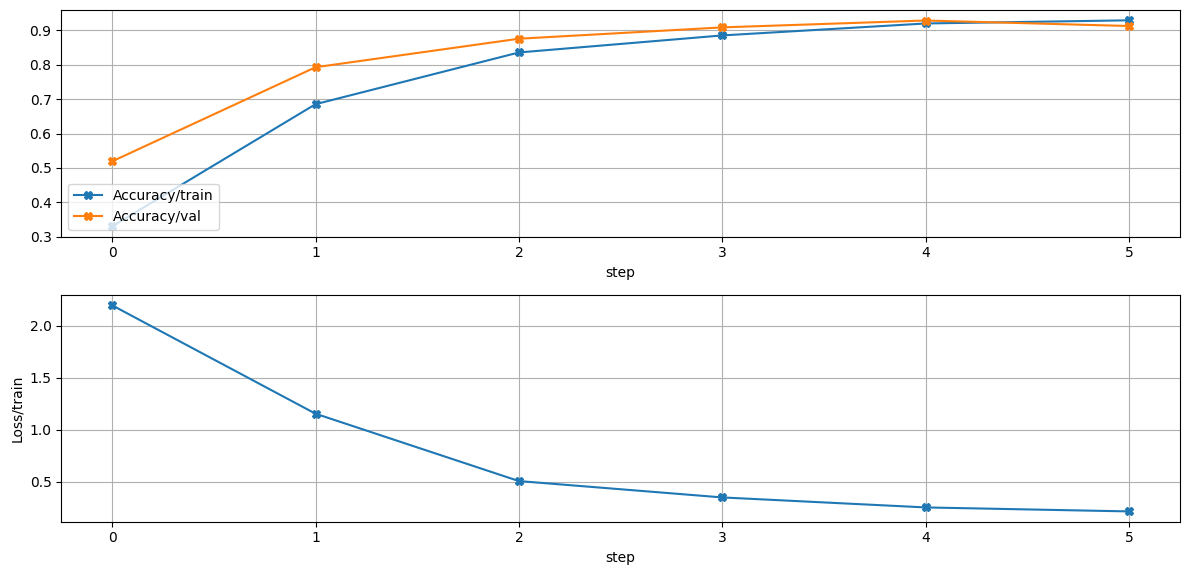

CPU times: user 10.6 s, sys: 731 ms, total: 11.3 s
Wall time: 10.7 s


In [49]:
%%time
model = TwoLayerCNN()
model.to(device)
model.train()
pp = train(model, train_loader, val_loader, lr=0.01, epochs=6)

In [54]:
class APCNN(nn.Module):
    def __init__(self, input_shape = (1, 28, 28)):
        super().__init__()
        x = 1
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 16, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(x),
            nn.Flatten(),
            nn.Linear(32*x**2, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        return self.conv(x)

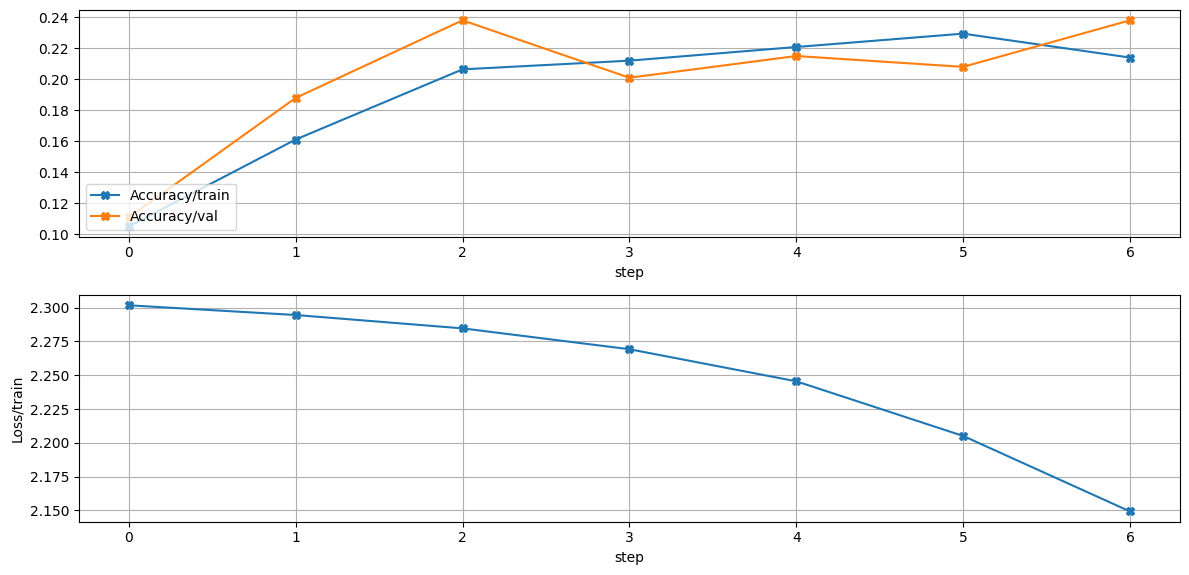

CPU times: user 12.2 s, sys: 855 ms, total: 13 s
Wall time: 12.2 s


In [55]:
%%time
model = APCNN()
model.to(device)
model.train()
pp = train(model, train_loader, val_loader, lr=0.01, epochs=7)